# Introducción

En este notebook se probará otro tipo de arquitectura como es el VAE para la reconstrucción de imágenes

In [36]:
import os
import numpy as np
from PIL import Image
from PIL import ImageFilter

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf

import random
import pathlib
from IPython import display

import pandas as pd

import time
import glob


In [37]:
train_input_dir =  './Datasets/Train/input/*.jpg'
train_target_dir =  './Datasets/Train/target_256_256/*.jpg'
test_input_dir =  './Datasets/Test/input/*.jpg'
test_target_dir =  './Datasets/Test/target_256_256/*.jpg'

In [38]:
BUFFER_SIZE = 10000
BATCH_SIZE = 2

In [39]:
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.cast(img, tf.float32)
    img = (tf.cast(img, tf.float32) / 255)
    return img

In [40]:
def preprocess_image(file_path_input):
    input_img = load_image(file_path_input)
    return input_img,input_img

In [41]:
train_target_dataset = tf.data.Dataset.list_files(train_target_dir, shuffle=False)
train_target_dataset = train_target_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_target_dataset = train_target_dataset.batch(BATCH_SIZE)

# Creación del Modelo

Ahora con nuestro dataset cargado vamos a entrenar un VAE para comprobar la restauración de las imágenes

In [71]:
class VAE(tf.keras.models.Model):


    def __init__(self,input_dim, latent_dim):
        super(VAE,self).__init__()

        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_dim),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), activation='relu', padding='same'),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim+latent_dim),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*512, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(4, 4, 512)),
            tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same'),
        ])
    
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, (self.latent_dim,)))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def log_normal_pdf(self,sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        sample = tf.cast(sample, tf.float32)
        mean = tf.cast(mean, tf.float32)
        logvar = tf.cast(logvar, tf.float32)
        return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


    def call(self,x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)

        self.add_loss(-tf.reduce_mean(logpx_z + logpz - logqz_x))

        return x_logit

In [65]:
LATENT_DIM = 4096
IMG_SIZE = (256,256,3)

In [66]:
vae = VAE(IMG_SIZE,LATENT_DIM)
vae.compile(loss = "mean_squared_error",optimizer='adam')

In [67]:
vae.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 512)       1180160   
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 512)         2359808   
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

In [46]:
vae.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              16785408  
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        2359808   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 512)      2359808   
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 128)      589952    
 ranspose)                                                       
                                                      

In [47]:
history = vae.fit(train_target_dataset,epochs = 100)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\DANIEL~1\AppData\Local\Temp\__autograph_generated_file03m97xzh.py", line 12, in tf__call
        x_logit = ag__.converted_call(ag__.ld(self).decode, (ag__.ld(z),), None, fscope)
    File "C:\Users\DANIEL~1\AppData\Local\Temp\__autograph_generated_file4i64ygp3.py", line 10, in tf__decode
        logits = ag__.converted_call(ag__.ld(self).decoder, (ag__.ld(z),), None, fscope)

    ValueError: Exception encountered when calling layer "vae" "                 f"(type VAE).
    
    in user code:
    
        File "C:\Users\Daniel Marin\AppData\Local\Temp\ipykernel_3600\489018307.py", line 66, in call  *
            x_logit = self.decode(z)
        File "C:\Users\Daniel Marin\AppData\Local\Temp\ipykernel_3600\489018307.py", line 49, in decode  *
            logits = self.decoder(z)
        File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 2048), found shape=(None, 1024)
    
    
    Call arguments received by layer "vae" "                 f"(type VAE):
      • x=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)


In [13]:
vae.save("./Checkpoints/VAE/")

INFO:tensorflow:Assets written to: ./Checkpoints/VAE/assets


INFO:tensorflow:Assets written to: ./Checkpoints/VAE/assets


In [68]:
vae = tf.keras.models.load_model("./Checkpoints/VAE/")

In [20]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

NameError: name 'history' is not defined

In [78]:
def encode(vae, x):
    mean, logvar = tf.split(vae.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

def reparameterize(vae, mean, logvar):
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(logvar * .5) + mean

def decode(vae, z, apply_sigmoid=False):
    logits = vae.decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

In [1]:
def generate_images(i):
    
    mean, logvar = encode(vae,i)
    z = reparameterize(vae,mean, logvar)
    prediction = decode(vae,z)

    plt.figure(figsize=(15, 15))

    display_list = [i[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i])
        plt.axis('off')
plt.show()

NameError: name 'plt' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


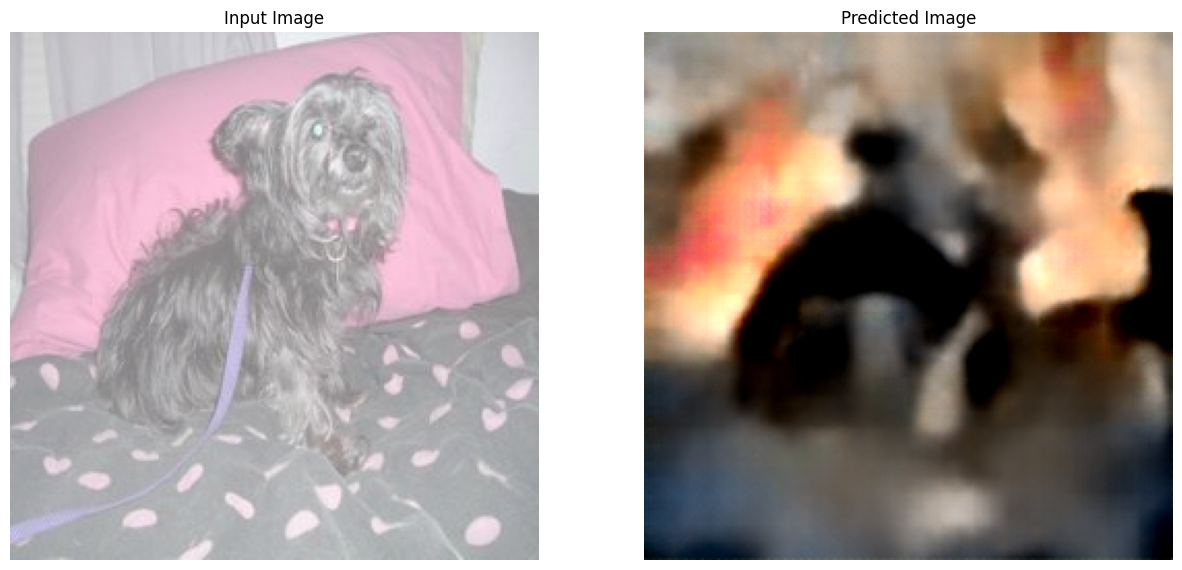

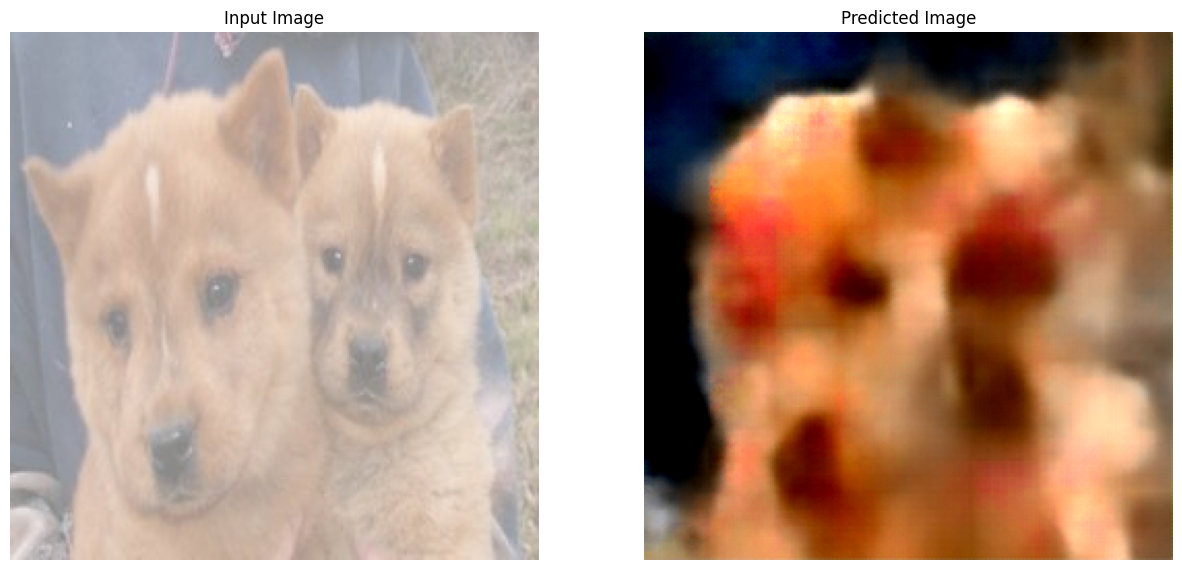

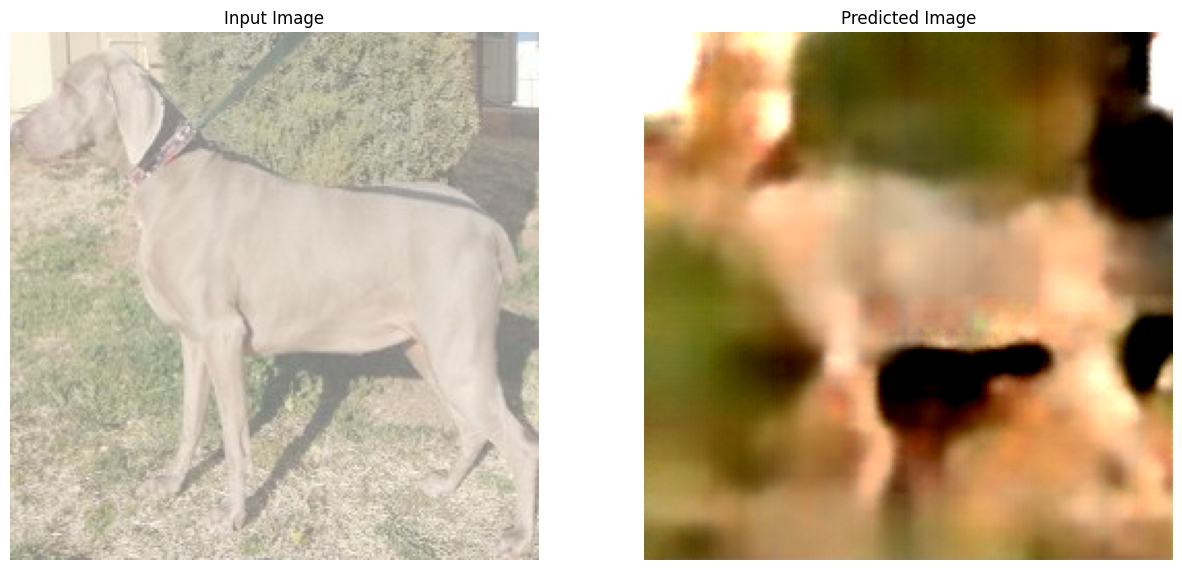

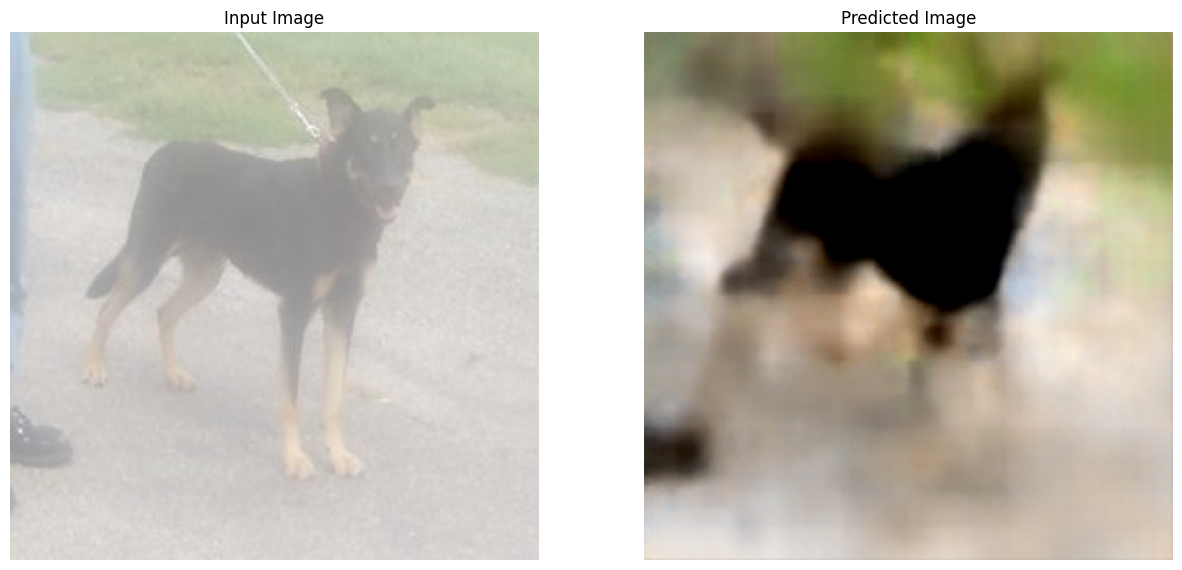

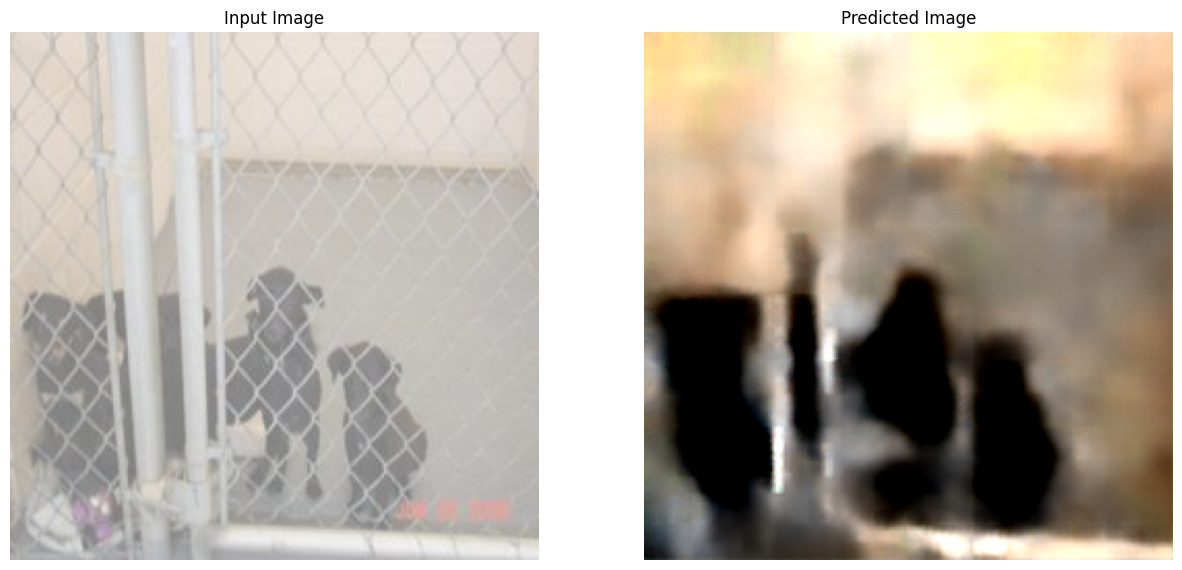

In [80]:
for i,i in train_target_dataset.take(5):

    i = np.expand_dims(i[0], axis=0)

    generate_images(i)
